In [1]:
from src import pipeline
from src import composite_analysis
import project_config

from importlib import reload
import os
import glob

import rasterio
from rasterio.plot import show
import geopandas as gpd

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx

cfg = project_config.get_config()
paths = cfg.paths
data_folder = paths.get_path('data')
raw_folder = paths.get_path('raw')
clipped_folder = paths.get_path('clipped')
stacked_folder = paths.get_path('stacked')
derived_folder = paths.get_path('derived')
classified_folder = paths.get_path('classified')
grid_analysis_folder = paths.get_path('grid_analysis')
proximity_analysis_folder = paths.get_path('proximity_analysis')
rois_folder = paths.get_path('rois')
rois_initial_analysis_dir = paths.get_path('rois_initial')
tests_folder = paths.get_path('tests')
envi_folder = paths.get_path('envi')

bands_to_keep = cfg.bands.to_dict()
composites = cfg.composites.get_all()
all_rois = cfg.rois.all_rois


In [2]:
# Default figure size
plt.rcParams['figure.figsize'] = (10, 8)

# Default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Optional: line widths and marker sizes
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6

# Deeper Analysis



In [40]:
reload(composite_analysis)
reload(project_config)

test_classified_tif = str(classified_folder) + '/LC08_L2SP_109060_20160603_20200907_02_T1_classified.tif'

class_raster, class_profile = composite_analysis.read_classification_raster(test_classified_tif)

display(class_profile['crs'])

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]')

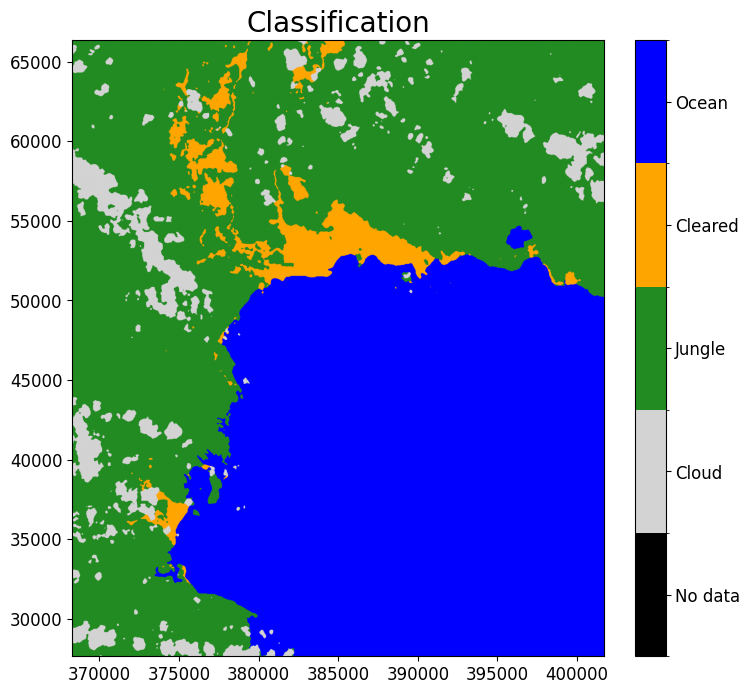

In [14]:

# class values and labels (adjust to your mapping)
class_vals = [-1, 0, 1, 2, 3]
labels = ['No data', 'Cloud', 'Jungle', 'Cleared', 'Ocean']

# colours in the same order as class_vals
cmap = mcolors.ListedColormap(['black', 'lightgrey', 'forestgreen', 'orange', 'blue'])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]  # boundaries between integer classes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 8))
# use the rasterio transform so the plot is georeferenced correctly
show(class_raster, transform=class_profile['transform'], ax=ax, cmap=cmap, norm=norm)
ax.set_title('Classification')
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=class_vals, fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(labels)
plt.show()

In [26]:
# Weda Bay Watch - Spatial Analysis Examples
# This notebook demonstrates the new grid and proximity analysis workflows

import sys
sys.path.append('..')

from src import pipeline
from claude_temp import classification, grid_analysis, proximity_analysis
from project_config import get_config
import pandas as pd
import numpy as np

reload(project_config)
reload(grid_analysis)

# =============================================================================
# 1. SETUP & CONFIGURATION
# =============================================================================

# Load or create config
cfg = get_config()

# Optionally save default config for future editing
# cfg.save_to_json('config.json')

# Access configuration
print("Composites:", cfg.composites.enabled)
print("Grid size:", cfg.analysis.grid_size_meters, "meters")
print("Buffer distances:", cfg.analysis.buffer_distances_meters)

# =============================================================================
# 2. WORKING WITH CLASSIFICATION FILES
# =============================================================================

# Example: Read a classification file and extract mine boundary
scene_name = "test"
class_path = test_classified_tif

# Read classification
class_array, profile = classification.read_classification_raster(class_path)
print(f"Classification shape: {class_array.shape}")
print(f"Unique classes: {np.unique(class_array)}")

# Get mine boundary as polygon
mine_boundary = classification.get_mine_boundary(
    class_path,
    buffer_meters=0,  # No buffer
    simplify_tolerance=10  # Simplify by 10m
)
print(f"Mine boundary area: {mine_boundary.geometry.area.values[0] / 1e6:.2f} km²")

# Get forest mask
forest_mask = classification.get_forest_mask(class_array)
print(f"Forest pixels: {forest_mask.sum():,}")

# =============================================================================
# 3. GRID-BASED ANALYSIS
# =============================================================================

# Create a grid over the study area
index_path = f"claude_temp/derived/{scene_name}/NDVI"
with rasterio.open(index_path) as src:
    bounds = src.bounds
    crs = src.crs

grid_gdf = grid_analysis.create_grid(
    bounds=bounds,
    cell_size_meters=cfg.analysis.grid_size_meters,
    crs=crs
)
print(f"Created grid with {len(grid_gdf)} cells")

# Compute statistics for one scene
grid_with_stats = grid_analysis.compute_grid_statistics(
    index_path=index_path,
    grid_gdf=grid_gdf,
    cloud_mask_path=f"claude_temp/derived/{scene_name}/QA_PIXEL",
    min_valid_fraction=cfg.analysis.min_valid_pixels_pct
)

# Add distance to mine
grid_with_stats = grid_analysis.calculate_distance_to_mine(
    grid_with_stats,
    mine_boundary
)

# View results
print(grid_with_stats[['cell_id', 'mean', 'distance_to_mine_m']].head())



Composites: ['RGB', 'NDVI', 'MNDWI', 'NDBI', 'EVI', 'SAVI', 'FERRIC_IRON', 'BAI', 'SI', 'NDGI', 'NDMI', 'CMI']
Grid size: 500 meters
Buffer distances: [500, 1000, 2000, 5000, 10000]
Classification shape: (1290, 1113)
Unique classes: [0 1 2 3]
Mine boundary area: 579.95 km²
Forest pixels: 58,028
Created grid with 5226 cells
    cell_id      mean  distance_to_mine_m
0  cell_0_0  0.426921            0.000000
1  cell_0_1  0.407588            0.000000
2  cell_0_2  0.414609          388.329757
3  cell_0_3  0.243849           44.721360
4  cell_0_4  0.146260            0.000000


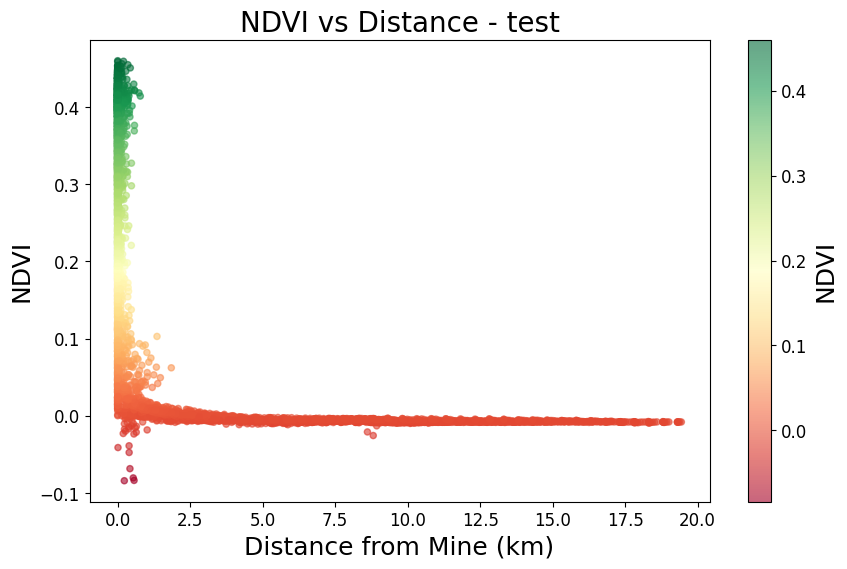

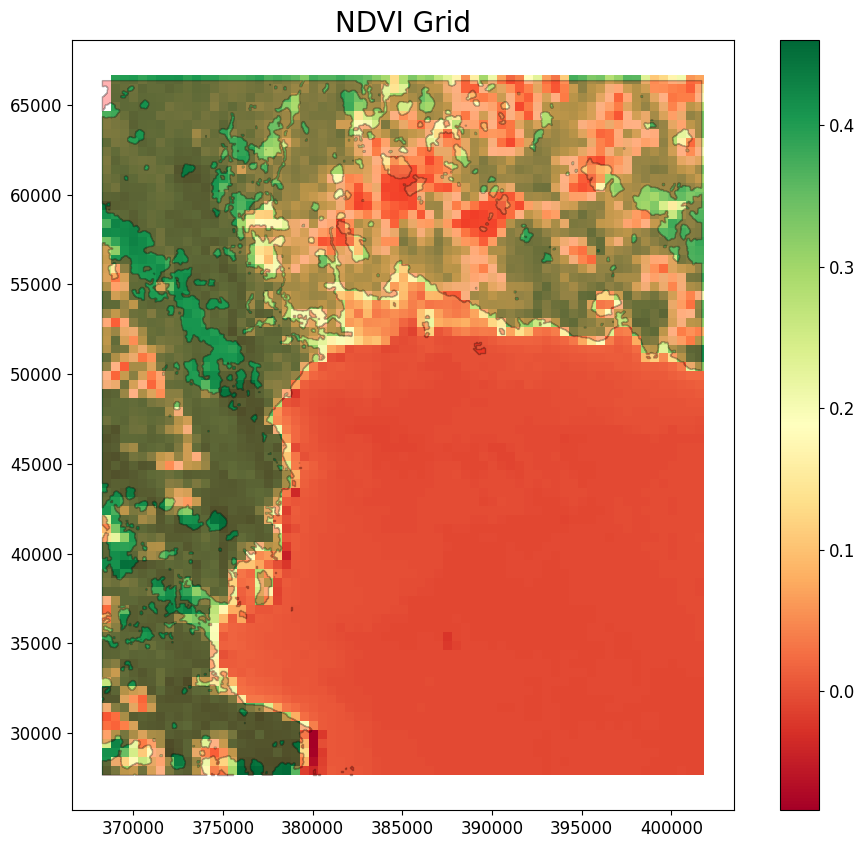

In [27]:
# Simple scatter plot: Distance vs NDVI
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    grid_with_stats['distance_to_mine_m'] / 1000,  # Convert to km
    grid_with_stats['mean'],
    c=grid_with_stats['mean'],
    cmap='RdYlGn',
    alpha=0.6,
    s=20
)
ax.set_xlabel('Distance from Mine (km)')
ax.set_ylabel('NDVI')
ax.set_title(f'NDVI vs Distance - {scene_name}')
plt.colorbar(scatter, label='NDVI')
plt.show()

# Plot as map
fig, ax = plt.subplots(figsize=(12, 10))
grid_with_stats.plot(
    column='mean',
    cmap='RdYlGn',
    legend=True,
    ax=ax,
    edgecolor='none'
)
mine_boundary.plot(ax=ax, facecolor='red', alpha=0.3, edgecolor='black')
ax.set_title('NDVI Grid')
plt.show()

In [ ]:
# =============================================================================
# 4. RUN GRID ANALYSIS FOR ALL SCENES
# =============================================================================

composite = 'NDVI'  # or any other from cfg.composites.enabled

grid_results = grid_analysis.grid_analysis_all_scenes(
    derived_folder='data/derived',
    clipped_folder='data/clipped',
    classified_folder='data/classified',
    output_folder=f'output/grid_analysis/{composite}',
    composite_name=composite,
    grid_size_meters=cfg.analysis.grid_size_meters,
    min_valid_fraction=cfg.analysis.min_valid_pixels_pct
)

print(f"Processed {len(grid_results)} scenes")

# =============================================================================
# 5. AGGREGATE AND VISUALIZE GRID RESULTS
# =============================================================================

# Aggregate by distance bins
distance_summary = grid_analysis.create_distance_summary(
    grid_results,
    stat='mean',
    distance_bins=[0, 500, 1000, 2000, 5000, 10000, 20000]
)

print("\nNDVI by distance from mine:")
print(distance_summary.describe())

# Plot over time, grouped by distance
grid_analysis.plot_grid_over_time(
    grid_results,
    stat='mean',
    distance_bins=[0, 1000, 2000, 5000, 10000],
    figsize=(14, 8)
)

# =============================================================================
# 6. PROXIMITY/BUFFER ANALYSIS
# =============================================================================

# Run proximity analysis for all scenes
proximity_df = proximity_analysis.proximity_analysis_all_scenes(
    derived_folder='data/derived',
    clipped_folder='data/clipped',
    classified_folder='data/classified',
    output_folder='output/proximity_analysis',
    composite_name='NDVI',
    buffer_distances=cfg.analysis.buffer_distances_meters
)

print("\nProximity analysis results:")
print(proximity_df.head())

# =============================================================================
# 7. VISUALIZE PROXIMITY RESULTS
# =============================================================================

# Plot NDVI over time at different distances
proximity_analysis.plot_proximity_over_time(
    proximity_df,
    buffer_distances=cfg.analysis.buffer_distances_meters,
    stat='mean',
    composite_name='NDVI',
    figsize=(14, 8)
)

# Calculate trends for each buffer zone
trends_df = proximity_analysis.calculate_proximity_trends(
    proximity_df,
    buffer_distances=cfg.analysis.buffer_distances_meters,
    stat='mean'
)

print("\nLinear trends by distance:")
print(trends_df)

# Compare mine vs far forest
proximity_analysis.compare_mine_vs_forest(
    proximity_df,
    mine_distance=500,  # 500m from mine
    forest_distance=10000,  # 10km from mine
    stat='mean',
    composite_name='NDVI'
)

# =============================================================================
# 8. MULTI-INDEX ANALYSIS
# =============================================================================

# Run for multiple composites
for composite in ['NDVI', 'EVI', 'SAVI', 'MNDWI']:
    print(f"\nProcessing {composite}...")
    
    proximity_df = proximity_analysis.proximity_analysis_all_scenes(
        derived_folder='data/derived',
        clipped_folder='data/clipped',
        classified_folder='data/classified',
        output_folder=f'output/proximity_analysis',
        composite_name=composite,
        buffer_distances=[500, 1000, 2000, 5000, 10000]
    )
    
    # Calculate trends
    trends = proximity_analysis.calculate_proximity_trends(
        proximity_df,
        buffer_distances=[500, 1000, 2000, 5000, 10000],
        stat='mean'
    )
    
    print(f"\n{composite} Trends:")
    print(trends[['slope_per_year', 'p_value', 'r_squared']])

# =============================================================================
# 9. EXPORT RESULTS
# =============================================================================

# Export distance summary for all scenes
distance_summary.to_csv('output/ndvi_distance_summary.csv')

# Export trends
trends_df.to_csv('output/ndvi_proximity_trends.csv')

print("\nAnalysis complete! Results saved to output/")

Grid: 340 cells; CRS: PROJCS["WGS 84 / UTM zone 52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]
BoundingBox(left=368295.0, bottom=27645.0, right=401685.0, top=66345.0)
EPSG:32652
(1290, 1113)
BoundingBox(left=368295.0, bottom=27645.0, right=401685.0, top=66345.0)
EPSG:32652
(1290, 1113)
BoundingBox(left=368295.0, bottom=27645.0, right=401685.0, top=66345.0)
EPSG:32652
(1290, 1113)


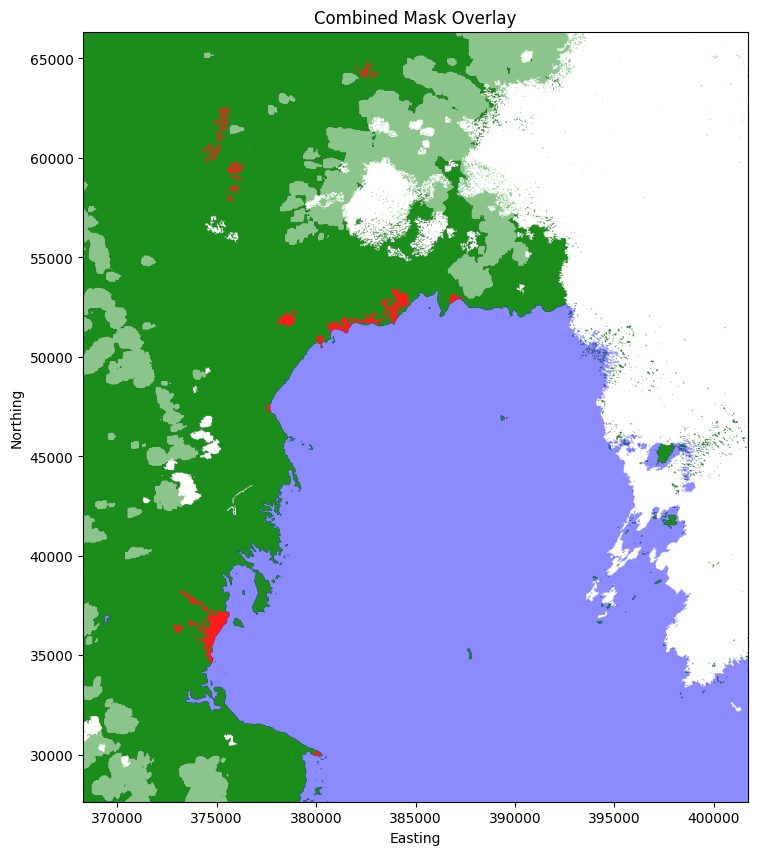

c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\claude_temp\grid_analysis.py:85: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  masked[masked[class_col] == cls].plot(ax=ax, color=color)


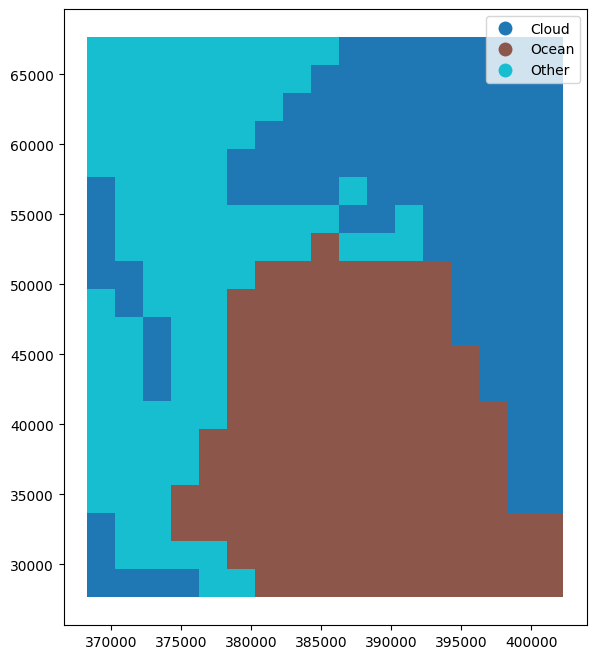

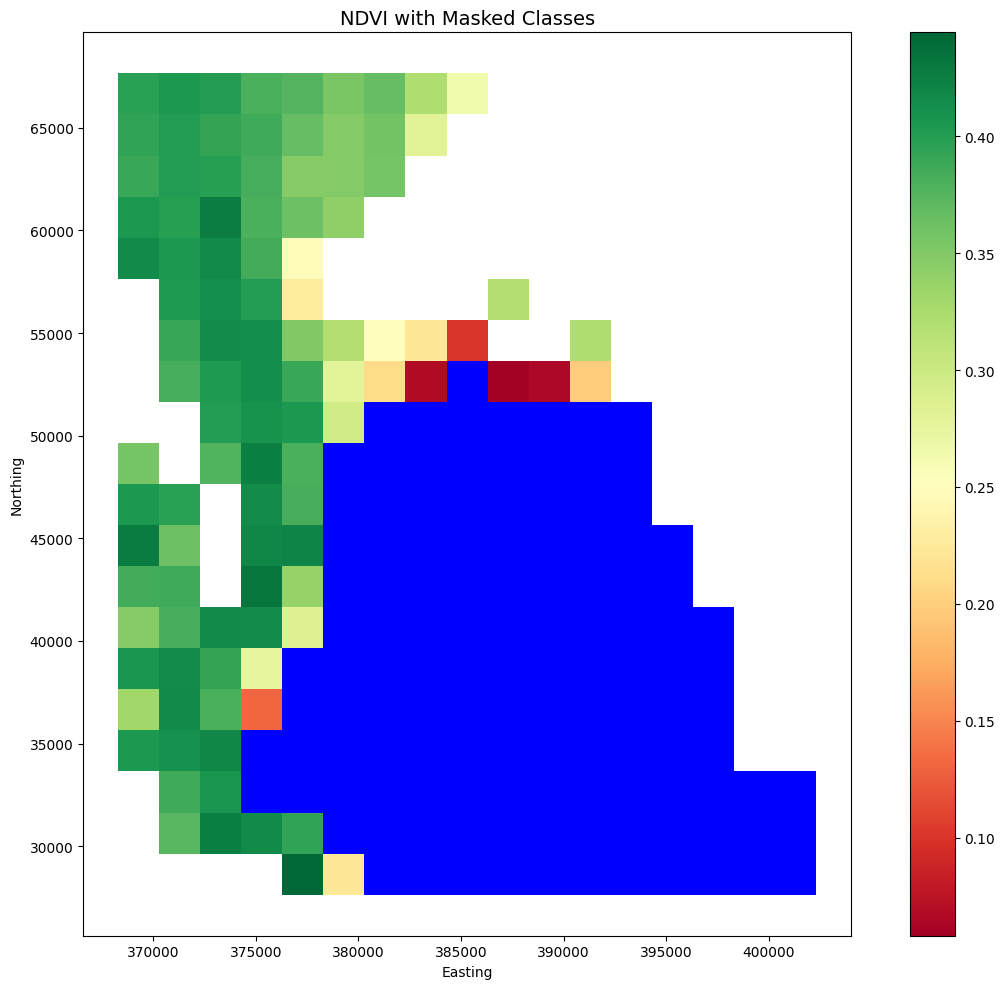

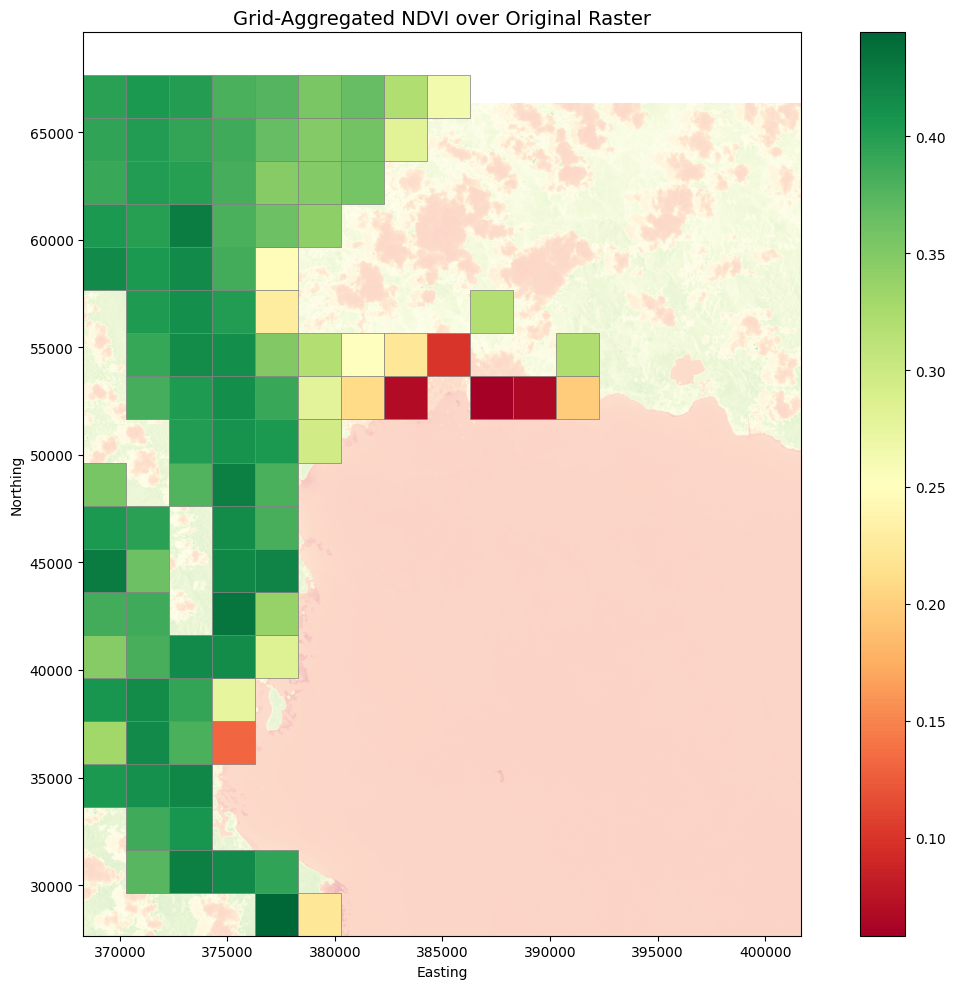

In [ ]:
# === GRID ANALYSIS - COMPLETE TEST WITH DEBUG ===

# Reload modules
import sys
if 'claude_temp.grid_analysis' in sys.modules:
    del sys.modules['claude_temp.grid_analysis']

import rasterio
import claude_temp.grid_analysis as ga
from claude_temp.grid_analysis import create_grid, compute_grid_statistics
from project_config import get_config

reload(ga)

cfg = get_config()
classifier = cfg.classifier

class_path = "output/classified/LC08_L2SP_109060_20160603_20200907_02_T1_classified.tif"
ndvi_path = "claude_temp/derived/test/NDVI"
qa_path = "claude_temp/derived/test/QA_PIXEL"

grid_size = 100
cloud_threshold = 0.3

with rasterio.open(class_path) as src:
    bounds = src.bounds
    crs = src.crs

grid_gdf = create_grid(bounds, grid_size, crs)
print(f"Grid: {len(grid_gdf)} cells; CRS: {grid_gdf.crs}")

with rasterio.open(class_path) as pok:
    print(pok.bounds)
    print(pok.crs)
    print(pok.shape)
with rasterio.open(ndvi_path) as pok:
    print(pok.bounds)
    print(pok.crs)
    print(pok.shape)
with rasterio.open(qa_path) as pok:
    print(pok.bounds)
    print(pok.crs)
    print(pok.shape)

g = ga.mask_grid_cells(grid_gdf, qa_path, class_path)


combined_mask, class_data, extent = ga.build_combined_mask(class_path, qa_path)
ga.plot_combined_mask(class_data, combined_mask, extent)

classified_grid = ga.apply_mask_to_grid(grid_gdf, class_path, qa_path, 100, cloud_threshold=0.3)
classified_grid.plot(column='dominant_class', categorical=True, legend=True, figsize=(10,8))

grid_with_ndvi = ga.compute_mean_ndvi_per_cell(classified_grid, ndvi_path)
ga.plot_ndvi_with_mask(grid_with_ndvi)
ga.plot_grid_ndvi_over_raster(ndvi_path, grid_with_ndvi)
